<a href="https://colab.research.google.com/github/Rohit1217/Flow/blob/main/Flow_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [59]:
!pip install matplotlib

In [60]:
import matplotlib.pyplot as plt
import numpy as np

import torch
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset,DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [61]:
Device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [62]:
transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)

data=trainset.data
data=data.to(dtype=torch.float32)
norm = transforms.Normalize((128,),(128,))
data=norm(data)
data_target=data*0.5+0.5
data=data.view(60000,784)
data=data.to(dtype=torch.float32)

data_target=data_target.view(60000,784)
trainset=TensorDataset(data,data_target)
trainloader=DataLoader(trainset,batch_size=256,shuffle=True)


In [63]:
def gaussian_pdf(x, mean, std_dev):
    return 1 / (torch.sqrt(2 * torch.tensor(np.pi)) * std_dev) * torch.exp(-0.5 * ((x - mean) / std_dev)**2)


In [64]:
class AffineCoupling(nn.Module):
  def __init__(self,input_layer):
    super(AffineCoupling,self).__init__()
    self.inp=input_layer//2
    self.fc1=nn.Linear(self.inp,1000).to(Device)
    self.fc2=nn.Linear(1000,1000).to(Device)
    self.fc3=nn.Linear(1000,1000).to(Device)
    self.fc4=nn.Linear(1000,1000).to(Device)
    self.fc5=nn.Linear(1000,self.inp).to(Device)
    #self.fc6=nn.Linear(1000,self.inp).to(Device)
    self.bn1=nn.BatchNorm1d(1000).to(Device)
    self.bn2=nn.BatchNorm1d(1000).to(Device)
    self.bn3=nn.BatchNorm1d(1000).to(Device)
    self.bn4=nn.BatchNorm1d(1000).to(Device)
    self.bn5=nn.BatchNorm1d(self.inp).to(Device)


  def coupling_shuffler(self,x):
    b,c=x.shape
    layer=torch.rand(b,c).to(Device)
    for i in range(c):
      if i%2==0:
        layer[:,c//2+i//2]=x[:,i]
      else:
        layer[:,i//2]=x[:,i]
    return layer

  def inverse(self,x):
    b,c=x.shape
    x0=x[:,:c//2]
    x1=x[:,c//2:]
    z=F.relu(self.bn1(self.fc1(x0)))
    z=F.relu(self.bn2(self.fc2(z)))
    z=F.relu(self.bn3(self.fc3(z)))
    z=F.relu(self.bn4(self.fc4(z)))
    z=F.relu(self.bn5(self.fc5(z)))
    x1=x1-z
    x=torch.cat((x0, x1), 1)
    layer=torch.rand(b,c).to(Device)
    for i in range(c):
      if i>=c//2:
        layer[:,2*i-c]=x[:,i]
      else:
        layer[:,i*2+1]=x[:,i]
    return layer


  def forward(self,x):
    b,c=x.shape
    x=self.coupling_shuffler(x)
    x0=x[:,:c//2]
    x1=x[:,c//2:]

    z=F.relu(self.bn1(self.fc1(x0)))
    z=F.relu(self.bn2(self.fc2(z)))
    z=F.relu(self.bn3(self.fc3(z)))
    z=F.relu(self.bn4(self.fc4(z)))
    z=F.relu(self.bn5(self.fc5(z)))

    x1=x1+z
    x=torch.cat((x0, x1), 1)
    return x

x=torch.randn(2,6)
print(x)
aff=AffineCoupling(6)
y=aff(x)
print(aff(x))
aff.inverse(y)


tensor([[-1.8699,  0.8490, -0.9151, -0.0214,  1.3118, -0.5883],
        [-1.6060,  0.5405,  1.0841,  0.0343,  0.4415, -1.2295]])
tensor([[ 0.8490, -0.0214, -0.5883, -1.8699, -0.9151,  1.3118],
        [ 0.5405,  0.0343, -1.2295, -0.6062,  2.0831,  1.4414]],
       device='cuda:0', grad_fn=<CatBackward0>)


tensor([[-1.8699,  0.8490, -0.9151, -0.0214,  1.3118, -0.5883],
        [-1.6060,  0.5405,  1.0841,  0.0343,  0.4415, -1.2295]],
       device='cuda:0', grad_fn=<CopySlices>)

In [65]:
class Flow(nn.Module):
  def __init__(self,input_layer):
    super(Flow,self).__init__()
    self.inp=input_layer
    self.ac1=AffineCoupling(input_layer)
    self.ac2=AffineCoupling(input_layer)
    self.ac3=AffineCoupling(input_layer)
    self.ac4=AffineCoupling(input_layer)
    self.w=nn.Parameter(torch.zeros(input_layer)).to(Device)

  def inverse(self,x):
    #x=torch.rand(self.inp)
    #x= torch.atanh(x-1e8)
    x=x*(torch.pow(torch.exp(self.w),-1))
    x=self.ac4.inverse(x)
    x=self.ac3.inverse(x)
    x=self.ac2.inverse(x)
    x=self.ac1.inverse(x)
    return x


  def forward(self,x):
    x=self.ac1(x)
    x=self.ac2(x)
    x=self.ac3(x)
    x=self.ac4(x)
    x=torch.exp(self.w)*x
    return x

x=torch.rand(2,782)
x=x.to(Device)
print(x)
flows=Flow(782)
y=flows(x)
x=flows.inverse(y)
print(y,x)


tensor([[0.0773, 0.4956, 0.1206,  ..., 0.7495, 0.3008, 0.3179],
        [0.7848, 0.0553, 0.6437,  ..., 0.1577, 0.8845, 0.2501]],
       device='cuda:0')
tensor([[0.8108, 0.6391, 0.4185,  ..., 3.8807, 0.9167, 3.3837],
        [0.9460, 0.1750, 0.9713,  ..., 1.6735, 4.3022, 1.3341]],
       device='cuda:0', grad_fn=<MulBackward0>) tensor([[ 0.0780,  0.4956, -0.8792,  ...,  0.7495,  1.3007,  0.3179],
        [ 0.7848,  0.0555,  1.6413,  ...,  0.1577, -0.1154,  0.2501]],
       device='cuda:0', grad_fn=<CopySlices>)


In [66]:
def loss_f(x,model):
  b,c=x.shape
  x=(torch.pow(x,2)/2)
  w=torch.sum(model.w)
  loss=x-w
  loss=torch.mean(loss)
  return loss
flow=Flow(784)
x=torch.randn(2,784)
y=flow(x)
loss_f(y,flow)

tensor(1.2973, device='cuda:0', grad_fn=<MeanBackward0>)

In [70]:
epochs=1000
model=Flow(784)
optimizer=optim.Adam(model.parameters(),lr=0.001)
model=model.to(Device)

In [76]:
model.train()
for epoch in range(epochs):
  total_loss=0
  count=0
  for input,_ in trainloader:
    input=input.to(Device)
    input=model(input)
    loss=loss_f(input,model)

    total_loss+=loss.item()
    count+=1

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  print(f'total_loss={total_loss},average_loss={total_loss/count}.epoch={epoch}')


total_loss=20.230407752096653,average_loss=0.08608684149828363.epoch=0


KeyboardInterrupt: 

In [ ]:
with torch.no_grad():
  #model.eval()
  x=data[:64]
  #print(x)
  #x=torch.randn(64,784)
  x=x.to('cuda:0')
  #x=flow(x)
  x = x.view(8, 8, 28, 28)
  x = x.to('cpu')
  image_np = x.detach().numpy()

  # Create a figure and a set of subplots arranged in an 8x8 grid
  fig, axes = plt.subplots(8, 8, figsize=(8, 8))

  # Iterate through the subplots and display each image
  for i in range(8):
      for j in range(8):
          axes[i, j].imshow(image_np[i, j], cmap='gray')
          axes[i, j].axis('off')  # Turn off axis labels

  plt.show()

tensor([-2.1213e+00, -2.2455e+00, -1.6178e+00, -2.7977e+00, -2.4593e+00,
         5.3189e-01, -9.2000e-01, -1.3725e+00,  2.8690e-01, -1.2369e+00,
        -1.3302e+00,  4.6122e-01,  1.4559e-01, -1.2197e+00, -3.0903e+00,
        -6.8017e-01, -4.1871e-01, -6.6138e-01,  1.2674e-01, -5.2696e-01,
        -1.0415e+00,  5.5686e-01, -1.9216e+00, -8.5705e-01, -3.2699e+00,
        -5.8998e-01, -1.0199e+00, -2.6186e+00,  5.3263e-01, -1.2336e-01,
         6.0348e-01, -1.1528e+00, -1.8714e+00, -4.4594e-01, -1.3183e+00,
        -2.4779e+00, -9.0549e-01, -2.1260e+00,  1.4499e+00, -4.1259e-01,
        -1.7617e+00, -1.0915e+00, -1.3275e+00, -1.1094e-01, -7.1680e-01,
        -1.0309e+00,  2.6173e-01, -1.4517e+00, -8.8197e-01, -2.7656e+00,
        -6.7191e-01, -5.1113e-01, -2.3459e+00, -8.1028e-01, -1.0573e+00,
        -2.0608e+00, -3.1599e+00,  1.5093e-01, -1.1200e+00, -1.5285e+00,
        -1.4755e+00, -7.0105e-01,  3.8145e-02, -7.0807e-02, -4.6648e-01,
         5.4868e-01, -1.4572e+00,  7.6756e-01, -1.3

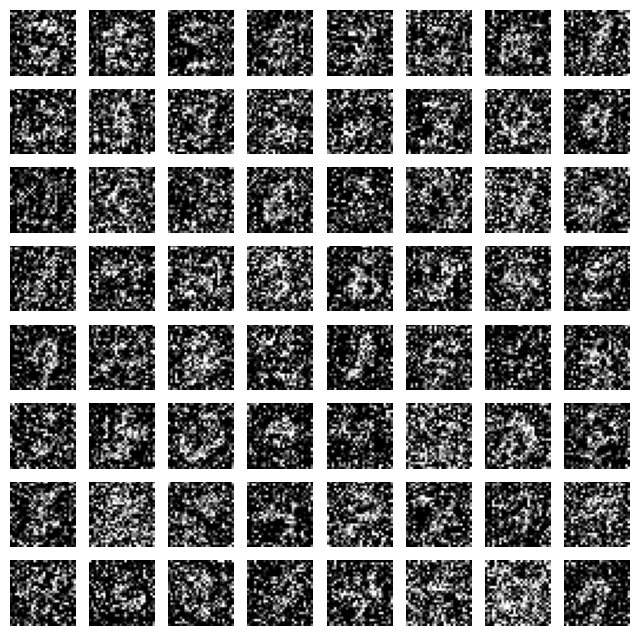

In [77]:
with torch.no_grad():
  #model.eval()
  x=data[:64]
  #print(x)
  x=torch.randn(64,784)
  x=x.to('cuda:0')
  #x=model(x)

  x=model.inverse(x)
  print(x[0])
  x = torch.clamp(x, min=-1, max=1)
  print(x[0])
  x=x*0.5+0.5
  print(x[0])
  x = x.view(8,8, 28, 28)
  x = x.to('cpu')
  image_np = x.detach().numpy()


  # Create a figure and a set of subplots arranged in an 8x8 grid
  fig, axes = plt.subplots(8, 8, figsize=(8, 8))

  # Iterate through the subplots and display each image
  for i in range(8):
      for j in range(8):
          axes[i, j].imshow(image_np[i, j], cmap='gray')
          axes[i, j].axis('off')  # Turn off axis labels

  plt.show()